In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from astropy.io import fits
from astropy.table import Table

from astroML.crossmatch import crossmatch_angular

In [2]:
def xmatch(cat1, cat2, flux_col_name1, flux_col_name2, max_distance, keep_columns = None):

    # Match cat1 with cat2, using max_radius in arcseconds
    distance_to_cat2, indices_of_cat2 = crossmatch_angular(cat1[["ra", "dec"]].values, cat2[["ra", "dec"]].values, max_distance=max_distance)
    matches_mask_to_cat2 = ~np.isinf(distance_to_cat2)

    matched_cat = pd.DataFrame({
        flux_col_name1: cat1[matches_mask_to_cat2][flux_col_name1].values,
        flux_col_name2: cat2.iloc[indices_of_cat2[matches_mask_to_cat2]][flux_col_name2].values,
        "distance": distance_to_cat2[matches_mask_to_cat2]*3600
    })

    # which columns to keep?
    if keep_columns is not None:
        for col in cat1.columns:
            if col != flux_col_name1:
                matched_cat[col] = cat1[matches_mask_to_cat2][col].values
        for col in cat2.columns:
            if col != flux_col_name2:
                matched_cat[col] = cat2.iloc[indices_of_cat2[matches_mask_to_cat2]][col].values
    return matched_cat

In [3]:
sr_cat_path = "/mnt/d/SPIRE-SR-AI/results/SwinUnet/SwinUnet2025May23HLR/testing/observations/cosmos_SR_catalog.fits"
sides_cat_path = "/mnt/g/data/PhD Projects/SR/sim_catalogs/SIDES_2_cat.fits"
shark_cat_path = "/mnt/g/data/PhD Projects/SR/sim_catalogs/SHARK_2_cat.fits"
floc_24_cat_path = "/mnt/g/data/PhD Projects/SR/obs_catalogs/a24_final_release_floc.dat"

In [4]:
shark_cat_table = Table.read(shark_cat_path)
shark_df = shark_cat_table.to_pandas()

sides_cat_table = Table.read(sides_cat_path)
sides_df = sides_cat_table.to_pandas()

sr_cat_table = Table.read(sr_cat_path)
sr_df = sr_cat_table.to_pandas()

floc24_df = pd.read_csv(floc_24_cat_path, sep='\s+', skiprows=16, header=None, names=['ra', 'dec', 'flux_24_mjy', 'flux_24_err_mjy'], usecols=[1, 2, 3, 4])

In [5]:
# Cut > 2mjy 500 micron

sides_df = sides_df[sides_df['SSPIRE500'] >= 2e-3]
shark_df = shark_df[shark_df['SSPIRE500'] >= 2e-3]

In [6]:
matched_24floc_500sr = xmatch(sr_df, floc24_df, flux_col_name1="S500SR", flux_col_name2="flux_24_mjy", max_distance=1/3600, keep_columns=['flux_24_err_mjy'])

# check for multiplets
matched_24floc_500sr = matched_24floc_500sr.groupby(['ra', 'dec']).filter(lambda group: len(group) == 1)

In [7]:
sides_df["mag_500"] = -2.5*np.log10(sides_df['SSPIRE500']/3631)
sides_df["mag_24"] = -2.5*np.log10(sides_df['SMIPS24']/3631)

shark_df["mag_500"] = -2.5*np.log10(shark_df['SSPIRE500']/3631)
shark_df["mag_24"] = -2.5*np.log10(shark_df['SMIPS24']/3631)

matched_24floc_500sr["mag_500"] = -2.5*np.log10(matched_24floc_500sr['S500SR']/3631)
matched_24floc_500sr["mag_24"] = -2.5*np.log10((matched_24floc_500sr['flux_24_mjy'] * 1e-3)/3631)

In [8]:
matched_24floc_500sr

,S500SR,flux_24_mjy,distance,ra,dec,file_id,flux_24_err_mjy,mag_500,mag_24
0,0.002302,0.354,0.465485,150.580892,1.509814,3,0.019,15.494830,17.527557
1,0.003489,0.158,0.178178,150.566179,1.514869,3,0.015,15.043433,18.403423
2,0.001519,0.091,0.505613,150.579732,1.527654,3,0.015,15.946295,19.002462
3,0.002123,0.509,0.449485,150.602780,1.529357,3,0.027,15.582455,17.133271
4,0.016992,6.347,0.529152,150.613341,1.546605,3,0.853,13.324440,14.393644
...,...,...,...,...,...,...,...,...,...
6916,0.003550,0.377,0.955534,149.832144,2.919435,394,0.021,15.024551,17.459212
6917,0.002877,0.290,0.553821,149.823999,2.921019,394,0.017,15.252538,17.744071
6918,0.007501,0.463,0.228205,149.827416,2.921565,394,0.017,14.212259,17.236113
6919,0.007702,0.282,0.527966,149.484972,2.865582,399,0.018,14.183501,17.774443


In [9]:
shark_df

,dec,ra,SMIPS24,SSPIRE250,SSPIRE350,SSPIRE500,mag_500,mag_24
12,-4.165023,214.181931,0.000246,0.007477,0.009392,0.008615,14.061974,17.922452
27,-3.992677,214.726471,0.000066,0.001592,0.002349,0.002326,15.483437,19.348393
66,-3.502719,214.263062,0.000239,0.008349,0.009672,0.008478,14.079311,17.951927
84,-4.450415,215.347595,0.000060,0.001297,0.002016,0.002012,15.640887,19.463303
105,-3.760286,214.287979,0.000061,0.002156,0.002460,0.002109,15.589742,19.435791
...,...,...,...,...,...,...,...,...
629392,-4.474069,213.568466,0.000068,0.002434,0.003239,0.002824,15.272982,19.312548
629439,-4.485382,214.451736,0.000055,0.002282,0.002732,0.002273,15.508506,19.552514
629441,-4.480072,214.402496,0.000229,0.010574,0.011876,0.009547,13.950398,18.002065
629452,-4.483228,214.424530,0.000066,0.003613,0.003572,0.002666,15.335380,19.356053


In [10]:
sr_df

,ra,dec,S500SR,file_id
0,150.815084,1.512177,0.002751,0
1,150.833822,1.513514,0.006046,0
2,150.806438,1.517636,0.003764,0
3,150.786219,1.518618,0.005012,0
4,150.790147,1.520569,0.003996,0
...,...,...,...,...
10674,149.480469,2.918069,0.005846,399
10675,149.475408,2.919686,0.009581,399
10676,149.431929,2.922300,0.010464,399
10677,149.449571,2.925095,0.004891,399


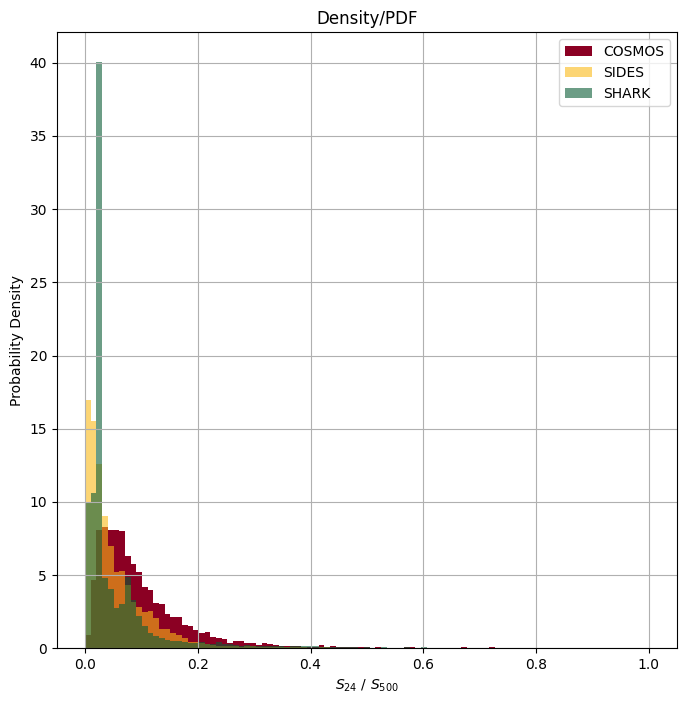

In [11]:
weights_cosmos = np.ones(len(matched_24floc_500sr)) / 2.2
weights_sides = np.ones(len(sides_df)) / 2.0
weights_shark = np.ones(len(shark_df)) / 2.0

bins = np.linspace(0, 1, 100)

plt.figure(figsize=(8,8))

plt.hist(matched_24floc_500sr['flux_24_mjy'] / (matched_24floc_500sr['S500SR']*1e3), bins=bins, color="#8b0023", density=True, label='COSMOS', weights=weights_cosmos)
plt.hist(sides_df['SMIPS24'] / sides_df['SSPIRE500'], bins=bins, color="#fbb917", alpha=0.6, density=True, label='SIDES', weights=weights_sides)
plt.hist(shark_df['SMIPS24'] / shark_df['SSPIRE500'], bins=bins, color="#0a5c36", alpha=0.6, density=True, label='SHARK', weights=weights_shark)

plt.xlabel(r'$S_{24}$ / $S_{500}$')
plt.ylabel('Probability Density')
plt.title('Density/PDF')
plt.legend()
plt.grid(True)


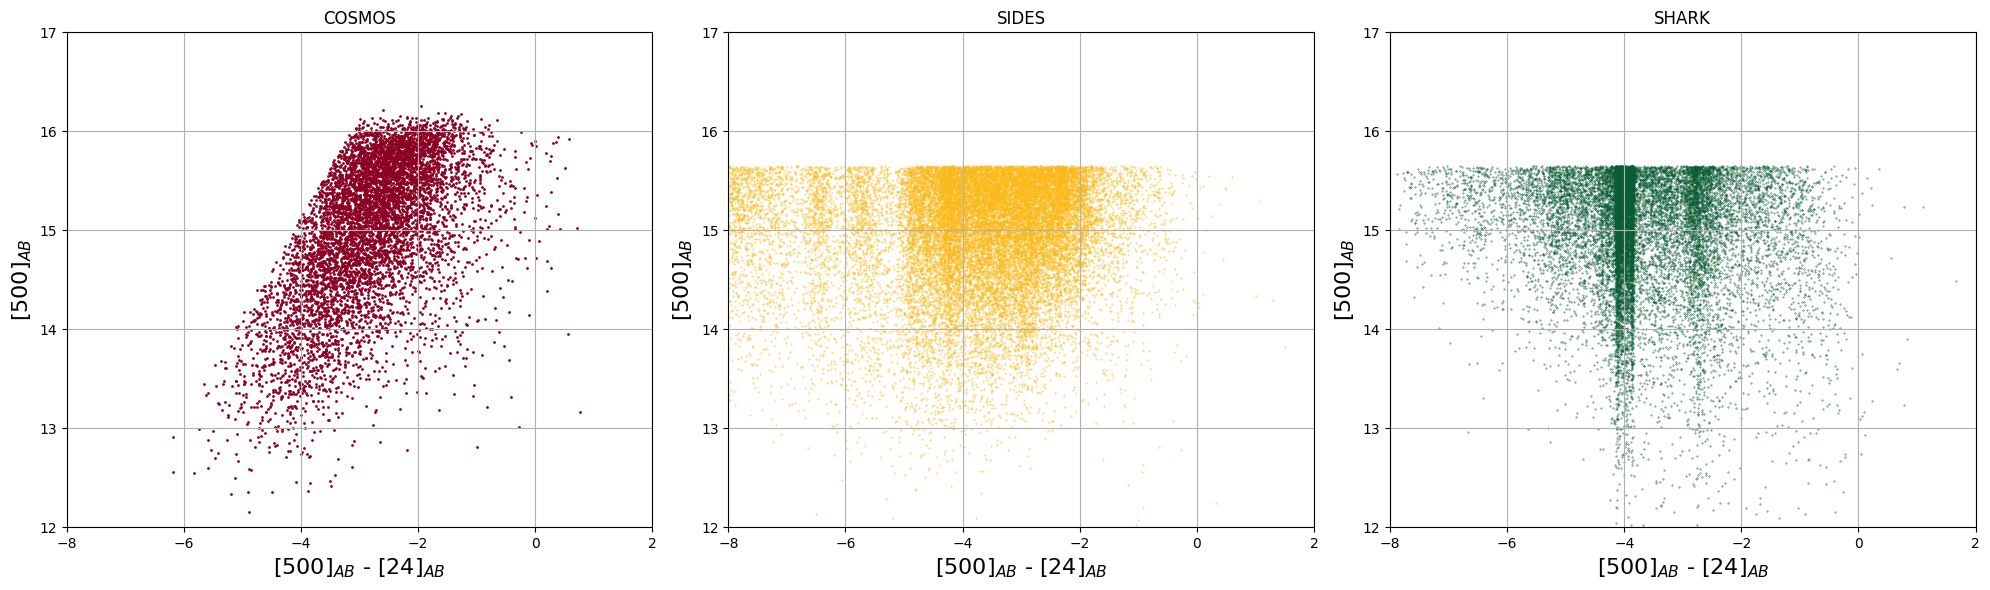

In [25]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6))

axs[0].scatter(matched_24floc_500sr['mag_500'] - matched_24floc_500sr['mag_24'],
               matched_24floc_500sr['mag_500'], color="#8b0023", s=1)
axs[0].set_xlabel(r'[500]$_{AB}$ - [24]$_{AB}$', fontsize=16)
axs[0].set_ylabel(r'[500]$_{AB}$', fontsize=16)
axs[0].set_title('COSMOS')
axs[0].grid(True)

axs[1].scatter(sides_df['mag_500'] - sides_df['mag_24'],
               sides_df['mag_500'], color="#fbb917", alpha=1, s=0.1)
axs[1].set_xlabel(r'[500]$_{AB}$ - [24]$_{AB}$', fontsize=16)
axs[1].set_ylabel(r'[500]$_{AB}$', fontsize=16)
axs[1].set_title('SIDES')
axs[1].grid(True)

axs[2].scatter(shark_df['mag_500'] - shark_df['mag_24'],
               shark_df['mag_500'], color="#0a5c36", alpha=1, s=0.1)
axs[2].set_xlabel(r'[500]$_{AB}$ - [24]$_{AB}$', fontsize=16)
axs[2].set_ylabel(r'[500]$_{AB}$', fontsize=16)
axs[2].set_title('SHARK')
axs[2].grid(True)

x_min = -8
x_max = 2

y_min = 12
y_max = 17

for ax in axs:
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)

plt.tight_layout()
plt.show()
